# Bag Of Vectors Sentiment Analysis with Timesteps

Using:

- RNN for dimensionality reduction of the input sequences
- Feedforward network to map to an output

In [1]:
import os, sys, csv, time, string, unicodedata
from collections import OrderedDict
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext as tt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Loading

In [2]:
!curl -fsS https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip -o /tmp/trainDevTestTrees_PTB.zip
!unzip -q -o -d ./data /tmp/trainDevTestTrees_PTB.zip
!rm -f /tmp/trainDevTestTrees_PTB.zip

In [3]:
def get_dataset(path):
    dataset = [[0, 0]]
    for line in open(path, 'r').readlines():
        soup = line.split()
        tokens = []
        for chunk in soup[2:]:
            if not chunk.endswith(")"):
                continue
            tokens.append(chunk.rstrip(')'))
        dataset.append([
            ' '.join(tokens), 
            int(soup[0].lstrip('('))])
    return dataset

with open("./data/train.csv", "w") as f:
    csv.writer(f).writerows(get_dataset("./data/trees/train.txt"))
with open("./data/val.csv", "w") as f:
    csv.writer(f).writerows(get_dataset("./data/trees/dev.txt"))
with open("./data/test.csv", "w") as f:
    csv.writer(f).writerows(get_dataset("./data/trees/test.txt"))

In [4]:
TEXT = tt.data.Field(tokenize = 'spacy')
LABEL = tt.data.LabelField()
fields = [('Text', TEXT), ('Label', LABEL)]

train_data, val_data, testds = tt.data.TabularDataset.splits(path='./data', 
                                            format='csv', 
                                            train='train.csv', 
                                            validation='val.csv', 
                                            test='test.csv',
                                            fields=fields, 
                                            skip_header=True)

/home/dojo/.pyenv/versions/3.8.6/envs/c0090/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/dojo/.pyenv/versions/3.8.6/envs/c0090/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/dojo/.pyenv/versions/3.8.6/envs/c0090/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example cl

In [5]:
# load pretrained vectors
import gensim.downloader as api
w2v = api.load('word2vec-google-news-300')

In [6]:
TEXT.build_vocab(train_data)

LABEL.build_vocab(train_data)

embedding_matrix = np.zeros((len(TEXT.vocab), 300))

for index,word in enumerate(TEXT.vocab.stoi):
    try:
        # update embedding matrix using pretrained vectors if defined
        embedding_matrix[index] = w2v[word] 
    except:
        # else keep as zero
        pass

# we want to convert it to a tensor when done
em = torch.from_numpy(embedding_matrix)
em.size()

torch.Size([17199, 300])

# Model Definition

We want to get embeddings for each word in a sentence, then corresponding vectors (so say for a sentence 'cat dog' we'd have a shape of 2x300), then we do pooling to obtain a fixed representation - i.e. no matter how many wods there are in a sentence, we'll have 1x300 resulting vector.

Then, we treat this vector as an input to a simple model, e.g. MLP.

In [55]:
class BoVModel(nn.Module):
    """
    Parameters
    ----------
    embedding_matrix: fully-formed matrix of pretrained word embeddings 
    freeze_embeddings: boolean, tells if embeddings should stay the same during model fitting
    num_of_class: output classes number
    mlp_dims: list of dimensionalities of hidden layers in mlp
    arch: What RNN type to use ["vanilla"], "lstm", "gru"
    dropout: model dropout rate for mlp hidden layers
    hidden_size: size of hidden state for the RNN (and cell state for LSTM)
    """
    def __init__(self, 
        embedding_matrix, freeze_embeddings, num_out_class,  mlp_dims,
        arch="vanilla", dropout=0.5, hidden_size=200):
        super(BoVModel, self).__init__()
        self.freeze_embeddings = freeze_embeddings
        self.arch = arch
        self.mlp_dims = mlp_dims
        self.num_out_class = num_out_class
        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=self.freeze_embeddings)
        
        if arch == "vanilla": self.rnn = nn.RNN(300, self.hidden_size)
        elif arch == "gru": self.rnn = nn.GRU(300, self.hidden_size)
        elif arch == "lstm": self.rnn = nn.LSTM(300, self.hidden_size)
        
        sizes = [self.hidden_size] + self.mlp_dims + [self.num_out_class]
        mlp = [nn.Dropout(dropout)]
        for i in range(0, len(sizes) - 1):
            mlp.append(nn.Linear(sizes[i], sizes[i+1]))
            if i < len(sizes) - 2: # Only apply to middle layers
                mlp.append(nn.ReLU())
                mlp.append(nn.Dropout(dropout))
        
        self.mlp = nn.Sequential(*mlp)
        print("MLP Arch:\n", self.mlp)

    def forward(self, input):
        # First, go through the embedding layer.
        x = self.embedding(input)
        # Then, run embedding through the RNN
        outputs, h = self.rnn(x)
        
        if self.arch == "lstm": h = h[0] # Get hidden layer since it is (h, c)
        
        # Finally, pass the results to MLP.
        x = self.mlp(h)
        return x

# Model Training

In [56]:
def show_metrics(model, epoch, best_seen=False):
    """Display the running metrics while training"""
    if best_seen: sys.stdout.write("* Epoch ")
    else: sys.stdout.write("  Epoch ")
    print('{:3.0f} | Train loss {:.5f} | Train acc {:.2%} | Val loss {:.5f} | Val acc {:.2%}'
            .format(epoch, model.train_losses[epoch], model.train_accs[epoch], 
                    model.val_losses[epoch], model.val_accs[epoch]))
    
def eval_model(model, data_iter, criterion):
    """Evaluate our model
    Parameters
    ------
    model - model to be evaluated
    data_iter - data iterator object
    criterion - loss function
    
    Returns
    -------
    accuracy - the dataset accuracy according to (correct / total)
    loss - the dataset loss according to criterion
    """
    acc, n_elems, loss = 0., 0, 0
    with torch.no_grad():
        for inputs, targets in data_iter:
            outputs = model(inputs).squeeze()
            loss += criterion(outputs, targets).item()
            acc += (outputs.argmax(axis=1) == targets).sum()
            n_elems += targets.numel()
    acc /= n_elems
    return acc.item(), loss / len(data_iter)
    
def train(model, train_iter, val_iter, criterion, model_path, n_epochs=300, init_patience=3):
    """Train our Bag of Vectors model
    Saves the best and final models to file, returns the best model
    Parameters
    ----------
    model - BoV model object
    train_iter - train data iterator
    val_iter - validation data iterator
    criterion - loss function
    model_path - directory to store model checkpoints in
    n_epochs - max number of epochs
    init_patience - max number of consecutively worse epochs to allow
    
    Returns
    -------
    best_model - a model checkpoint from the best observed model
    """
    # Store metrics for the model
    model.train_accs = np.zeros(n_epochs)
    model.train_losses = np.zeros(n_epochs)
    model.val_accs = np.zeros(n_epochs)
    model.val_losses = np.zeros(n_epochs)
    best_model = deepcopy(model)
    
    # 300 epochs is chosen from observing that most models converged between 100-200 epochs.
    epoch, patience = 0, init_patience
    
    model.train_accs[epoch], model.train_losses[epoch] = eval_model(model, train_iter, criterion)
    model.val_accs[epoch], model.val_losses[epoch] = eval_model(model, val_iter, criterion)
    show_metrics(model, epoch)
    epoch += 1
    
    while epoch < n_epochs and patience > 0:
        # Prepare model for training.
        model.train()
        for sentences, labels in train_iter:
            model.zero_grad() 
            outputs = model(sentences).squeeze() # Forward pass.
            loss = criterion(outputs, labels) # Compute loss with CrossEntropyLoss
            loss.backward() # Backprop
            optimizer.step() # Update params
        
        model.eval()
        model.train_accs[epoch], model.train_losses[epoch] = eval_model(model, train_iter, criterion)
        model.val_accs[epoch], model.val_losses[epoch] = eval_model(model, val_iter, criterion)

        # Save the best model for later
        if epoch < 2 or model.val_losses[epoch] < model.val_losses[:epoch].min():
            best_model = deepcopy(model)
            best_model.train_accs = model.train_accs[:epoch+1]
            best_model.train_losses = model.train_losses[:epoch+1]
            best_model.val_accs = model.val_accs[:epoch+1]
            best_model.val_losses = model.val_losses[:epoch+1]
            torch.save(best_model, os.path.join(model_path, "best_model.torchmodel"))
            show_metrics(model, epoch, best_seen=True)
        else: show_metrics(model, epoch)
            
        # Check for convergence
        if model.val_losses[epoch] > model.val_losses[epoch - 1]: patience -= 1
        else: patience = init_patience
        
        epoch += 1
    
    # Remove unused epochs
    model.train_accs = model.train_accs[:epoch]
    model.train_losses = model.train_losses[:epoch]
    model.val_accs = model.val_accs[:epoch]
    model.val_losses = model.val_losses[:epoch]
    
    torch.save(model, os.path.join(model_path, "final_model.torchmodel"))
    print("""*********** DONE **********\n 
        Validation accuracy at best epoch {} was {:.2%}. Returning that model."""
        .format(model.val_losses.argmin(), model.val_accs[model.val_losses.argmin()]))
    return best_model

In [58]:
bov_model = BoVModel(
    embedding_matrix=em,
    freeze_embeddings=True,
    num_out_class=5,
    mlp_dims=[128, 16],
    arch="gru", # ["vanilla"], "lstm"
    dropout=0,
    hidden_size=256,
).to(device)

MLP Arch:
 Sequential(
  (0): Dropout(p=0, inplace=False)
  (1): Linear(in_features=256, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0, inplace=False)
  (4): Linear(in_features=128, out_features=16, bias=True)
  (5): ReLU()
  (6): Dropout(p=0, inplace=False)
  (7): Linear(in_features=16, out_features=5, bias=True)
)


In [59]:
batch_size=64
lr = 1e-4
optimizer = optim.Adam(filter(lambda p: p.requires_grad, bov_model.parameters()), lr=lr)
criterion = nn.CrossEntropyLoss()

train_iter, val_iter = tt.data.BucketIterator.splits(datasets=(train_data, val_data),
    batch_sizes=(batch_size, batch_size), sort_key=lambda x: len(x.Text),
    device=device, sort_within_batch=False, shuffle=True)

model_path = "./models/{}-{}".format("BoVRNN", time.strftime("%m-%d-%H%M", time.gmtime()))
try: os.mkdir(model_path)
except FileExistsError: print("Directory Exists... Skipping")
print("Model folder: {}".format(model_path))

best_model = train(bov_model.double(), train_iter, val_iter, criterion, model_path, n_epochs=200, init_patience=5)
final_model = deepcopy(bov_model)

Model folder: ./models/BoV-12-15-0004
  Epoch   0 | Train loss 1.60910 | Train acc 19.04% | Val loss 1.60636 | Val acc 20.16%
* Epoch   1 | Train loss 1.56920 | Train acc 27.18% | Val loss 1.57509 | Val acc 26.79%
* Epoch   2 | Train loss 1.56779 | Train acc 27.18% | Val loss 1.57370 | Val acc 27.07%
* Epoch   3 | Train loss 1.56663 | Train acc 27.18% | Val loss 1.57277 | Val acc 27.97%
* Epoch   4 | Train loss 1.56621 | Train acc 27.18% | Val loss 1.57176 | Val acc 27.79%
* Epoch   5 | Train loss 1.56260 | Train acc 29.23% | Val loss 1.57069 | Val acc 31.79%
* Epoch   6 | Train loss 1.54594 | Train acc 32.39% | Val loss 1.56745 | Val acc 30.43%
* Epoch   7 | Train loss 1.47528 | Train acc 36.60% | Val loss 1.52089 | Val acc 33.97%
* Epoch   8 | Train loss 1.39914 | Train acc 39.31% | Val loss 1.46050 | Val acc 36.69%
* Epoch   9 | Train loss 1.35862 | Train acc 40.64% | Val loss 1.43824 | Val acc 37.69%
* Epoch  10 | Train loss 1.34134 | Train acc 41.30% | Val loss 1.43688 | Val acc 3

# Model Evaluation

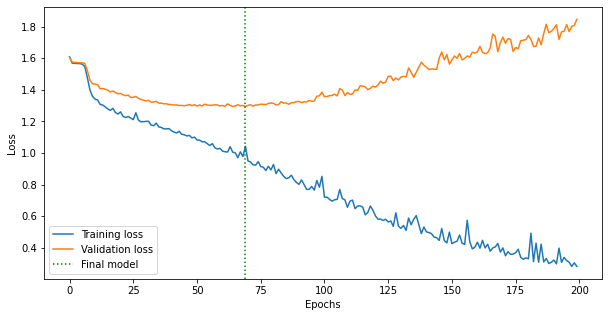

In [60]:
plt.figure(figsize=(10,5))
plt.plot(final_model.train_losses, label="Training loss")
plt.plot(final_model.val_losses, label="Validation loss")
plt.axvline(final_model.val_losses.argmin(), linestyle='dotted', color='g',label='Final model')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(model_path, "losses.png"))

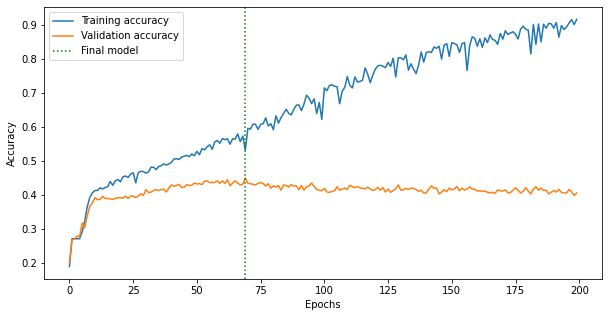

In [61]:
plt.figure(figsize=(10,5))
plt.plot(final_model.train_accs, label="Training accuracy")
plt.plot(final_model.val_accs, label="Validation accuracy")
plt.axvline(final_model.val_losses.argmin(), linestyle='dotted', color='g',label='Final model')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(model_path, "accs.png"))

# Evaluating on Test Set

In [62]:
# Obtain best epoch accuracies and add a newly obtained test set value.
test_iter = tt.data.Iterator(testds, batch_size=batch_size,
    sort_key=lambda x: len(x.Text), device=device, sort_within_batch=False)
test_acc, _ = eval_model(best_model, test_iter, criterion)

print("Training Accuracy: {:.2%}".format(best_model.train_accs[best_model.val_accs.argmax()]))
print("Validation Accuracy: {:.2%}".format(best_model.val_accs.max()))
print("Test Accuracy: {:.2%}".format(test_acc))

/home/dojo/.pyenv/versions/3.8.6/envs/c0090/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/dojo/.pyenv/versions/3.8.6/envs/c0090/lib/python3.8/site-packages/torch/nn/modules/rnn.py:739: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


Training Accuracy: 53.15%
Validation Accuracy: 44.96%
Test Accuracy: 44.21%


# Testing on Unseen Reviews

In [28]:
# Reviews source: https://www.rottentomatoes.com/m/a_quiet_place_2018/reviews?type=user

reviews = [
    "Very well done , from acting to cinematography all first rate.",
    "I have seen a lot of terrible movies in my life and this was the worst by far!",
    "As far as horror movies go , this is one of the only ones in my life that I felt I wasted my time that I wo n't get back.",
    "Cheap move using Deaf culture as the only interesting feature.",
    "honestly amazing , I was literally holding my breath through out the movie, Emily Blunt and John Krasinski were brilliant the whole way.",
]

field = [('Text', TEXT)]

with open("./data/examples.csv", "w") as f:
    csv.writer(f).writerows([[r] for r in reviews])
    
example_data = tt.data.TabularDataset(path='./data/examples.csv', 
                format='csv', fields=field)

example_iter = tt.data.Iterator(example_data, batch_size=1, device=device, shuffle=False)

best_model.eval()
pred_idxs = []
with torch.no_grad():
    for inputs, _ in example_iter:
        outputs = best_model(inputs).squeeze()
        pred_idxs_tensor = outputs.argmax(axis=-1)
        pred_idxs.append(pred_idxs_tensor.item())

for i in range(len(pred_idxs)):
    print("Review {} - Predicted Rating: {}:\n  {}".format(i, pred_idxs[i], reviews[i]))

Review 0 - Predicted Rating: 0:
  Very well done , from acting to cinematography all first rate.
Review 1 - Predicted Rating: 4:
  I have seen a lot of terrible movies in my life and this was the worst by far!
Review 2 - Predicted Rating: 4:
  As far as horror movies go , this is one of the only ones in my life that I felt I wasted my time that I wo n't get back.
Review 3 - Predicted Rating: 1:
  Cheap move using Deaf culture as the only interesting feature.
Review 4 - Predicted Rating: 0:
  honestly amazing , I was literally holding my breath through out the movie, Emily Blunt and John Krasinski were brilliant the whole way.
